# `micapipe v0.2.0` | PNI 7T - MICs 3T | backwards compatible

In [233]:
# Set the environment
import os
import numpy as np
import matplotlib as plt
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.datasets.base import load_mask
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns
import matplotlib.pyplot as mpl

# This variable will be different for each subject
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
tesla='3T'
if tesla == '3T':
    recon='freesurfer'
    derivatives='/data_/mica3/BIDS_MICs/derivatives'
    sub='sub-HC062'
    func_acq='desc-se_task-rest_acq-AP_bold'
else:
    recon='fastsurfer'
    derivatives='/data_/mica3/BIDS_PNI/derivatives_dev'
    sub='sub-PNC002'
    func_acq='desc-me_task-rest_bold'
    
subjectID=sub+'_ses-01'
out=derivatives+ '/micapipe_v0.2.0/'
subjectDir=out + sub+'/ses-01'

# Set the working directory to the 'out' directory
os.chdir(out) 

# Set paths and variables
dir_FS = derivatives+'/'+recon+'/' + subjectID

# Load native pial surface
def load_surf(label='pial', surf='fsnative'):
    gm_lh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-L_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    gm_rh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-R_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    return (gm_lh, gm_rh)

def load_feat(label='thickness', surf='fsnative'):
    dat_lh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-L_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat_rh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-R_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat = np.concatenate((dat_lh, dat_rh), axis=0)
    return (dat)

def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', Vmin=None, Vmax=None):
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = mpl.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=Vmin, vmax=Vmax)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

# Colormap
ColCurv= plt.colors.ListedColormap(['#A2CD5A', '#A0CA5B', '#9FC85C', '#9EC55D', '#9DC35E', '#9CC05F', '#9BBE61', '#9ABB62', '#99B963', '#98B664', '#96B465', '#95B166', '#94AF68', '#93AC69', '#92AA6A', '#91A76B', '#90A56C', '#8FA26D', '#8EA06F', '#8C9D70', '#8B9B71', '#8A9972', '#899673', '#889475', '#879176', '#868F77', '#858C78', '#848A79', '#82877A', '#81857C', '#80827D', '#7F807E', '#807D7D', '#827A7A', '#857777', '#877575', '#8A7272', '#8C6F6F', '#8F6C6C', '#916969', '#946666', '#966464', '#996161', '#9B5E5E', '#9D5B5B', '#A05858', '#A25656', '#A55353', '#A75050', '#AA4D4D', '#AC4A4A', '#AF4747', '#B14545', '#B44242', '#B63F3F', '#B93C3C', '#BB3939', '#BE3636', '#C03434', '#C33131', '#C52E2E', '#C82B2B', '#CA2828', '#CD2626'])
grey = plt.colors.ListedColormap(np.full((256, 4), [0.65, 0.65, 0.65, 1]))

from brainspace.datasets import load_parcellation
labeling = load_parcellation('schaefer', scale=400, join=True)
mask = labeling != 0

# Load Canonical surfaces NOTE: MAKE A FETCHER SCRIPT SAVE MEMORY USAGE
# inflated native
# Load native inflated surface
inf_lh = read_surface(dir_FS+'/surf/lh.inflated', itype='fs')
inf_rh = read_surface(dir_FS+'/surf/rh.inflated', itype='fs')

# fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_lhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
fs5_rhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.inflated', itype='fs')

# fsLR-32k
c69_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.surf.gii', itype='gii')
c69_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.surf.gii', itype='gii')
c69_lhi = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_rhi = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
c69_lm = read_surface(micapipe + '/surfaces/fsLR-32k.L.midthickness.surf.gii', itype='gii')
c69_rm = read_surface(micapipe + '/surfaces/fsLR-32k.R.midthickness.surf.gii', itype='gii')
# fsLR-32k - regular sphere
c69_lhs = read_surface(micapipe + '/surfaces/fsLR-32k.L.sphere.surf.gii', itype='gii')
c69_rhs = read_surface(micapipe + '/surfaces/fsLR-32k.R.sphere.surf.gii', itype='gii')
# fsLR-32k - sphere for registration
c69_lhsr = read_surface(micapipe + '/surfaces/fsLR-32k.L.sphere.reg.surf.gii', itype='gii')
c69_rhsr = read_surface(micapipe + '/surfaces/fsLR-32k.R.sphere.reg.surf.gii', itype='gii')

# fsLR-5k
c5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
c5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')
c5k_lhi = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
c5k_rhi = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# fsLR-5k - regular sphere
c5k_lhs = read_surface(micapipe + '/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
c5k_rhs = read_surface(micapipe + '/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')
# fsLR-5k - sphere for registration
c5k_lhsr = read_surface(micapipe + '/surfaces/fsLR-5k.L.sphere.reg.surf.gii', itype='gii')
c5k_rhsr = read_surface(micapipe + '/surfaces/fsLR-5k.R.sphere.reg.surf.gii', itype='gii')


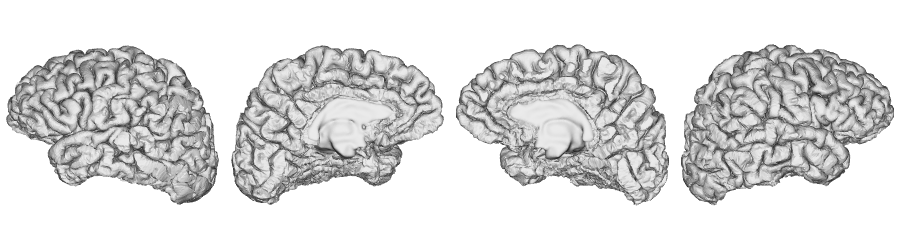

In [183]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsnative')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

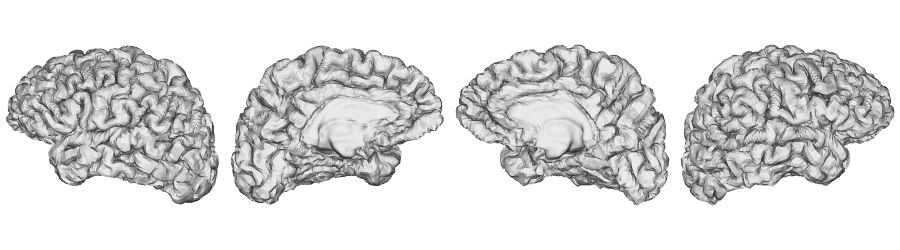

In [184]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

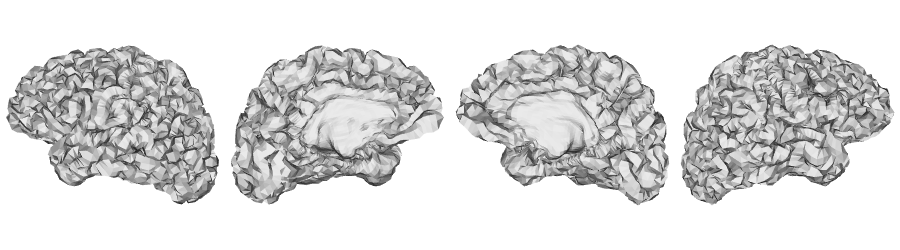

In [185]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

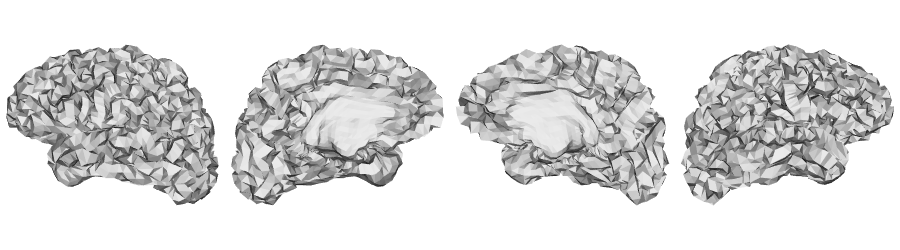

In [186]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

# Thickness: fsnative

## `fsnative` 

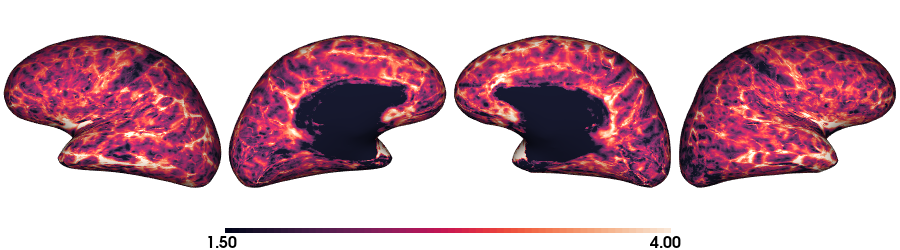

In [191]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsnative')
feat = load_feat(label='thickness', surf='fsnative')
plot_hemispheres(inf_lh, inf_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False, color_bar='bottom')

## `fsaverage5`

(20484,)


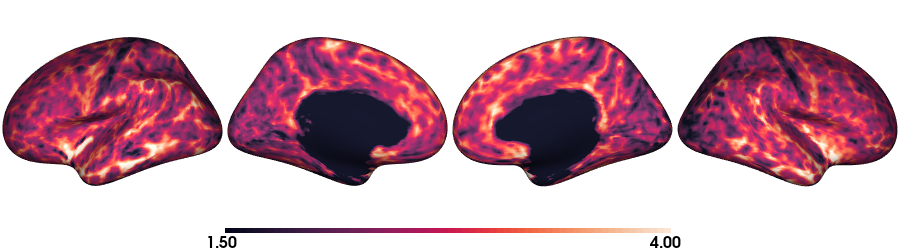

In [189]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsaverage5')
print(feat.shape)
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(fs5_lhi, fs5_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,  color_bar='bottom')

## `fsLF-32k`

(64984,)


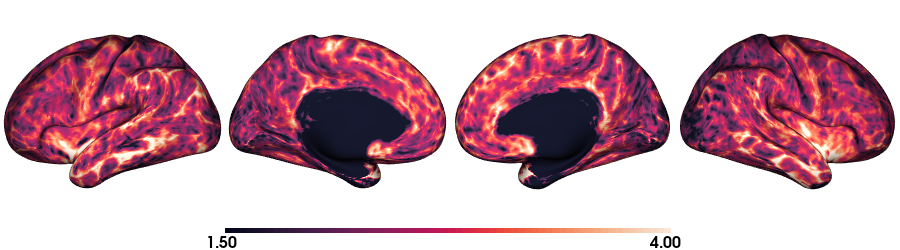

In [192]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsLR-32k')
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
print(feat.shape)
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,  color_bar='bottom',
                screenshot=False, filename='/host/yeatman/local_raid/rcruces/tmp/fsLR-32k_inflated_thickness.png')

# fsLR-32k `sphere`

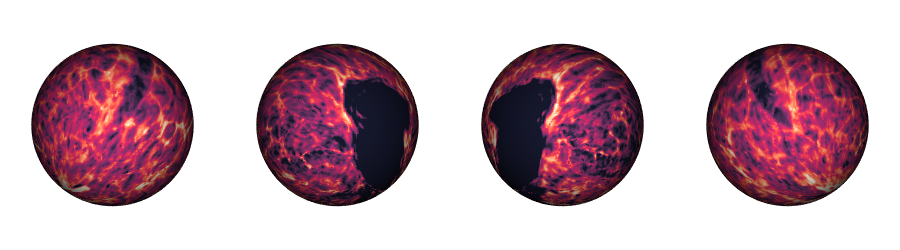

In [193]:
plot_hemispheres(c69_lhs, c69_rhs,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,
                screenshot=False, filename='/host/yeatman/local_raid/rcruces/tmp/fsLR-32k_inflated_thickness.png')

# fsLR-32k `sphere.reg`

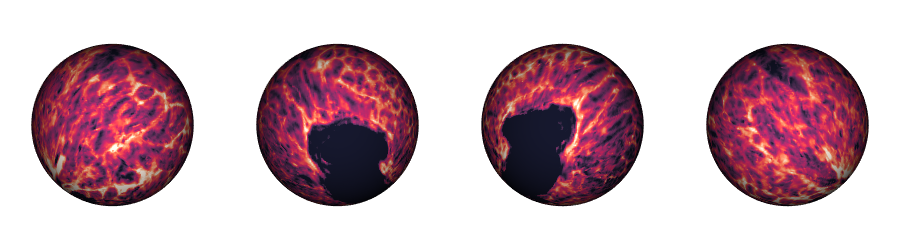

In [194]:
plot_hemispheres(c69_lhsr, c69_rhsr,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,
                screenshot=False, filename='/host/yeatman/local_raid/rcruces/tmp/fsLR-32k_inflated_thickness.png')

# fsLR-32k `midthickness`

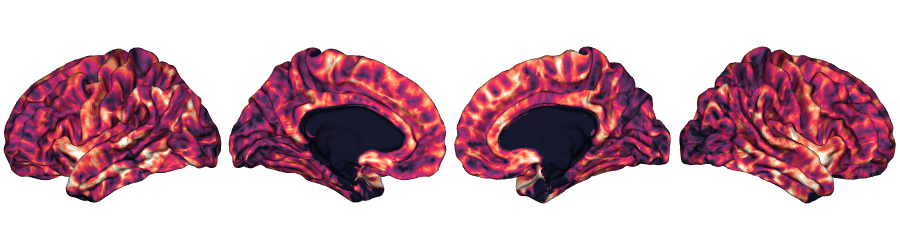

In [195]:
plot_hemispheres(c69_lm, c69_rm,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,
                screenshot=False, filename='/host/yeatman/local_raid/rcruces/tmp/fsLR-32k_inflated_thickness.png')

## `fsLR-5k` 

(9684,)


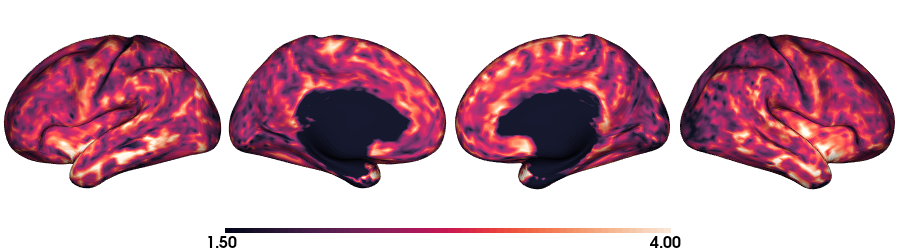

In [196]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsLR-5k')
print(feat.shape)
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
# Plot the surface
plot_hemispheres(c5k_lhi, c5k_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,  color_bar='bottom',
                screenshot=False, filename='/host/yeatman/local_raid/rcruces/fsLR-5k_inflated_thickness.png')

## `fsLR-5k` native

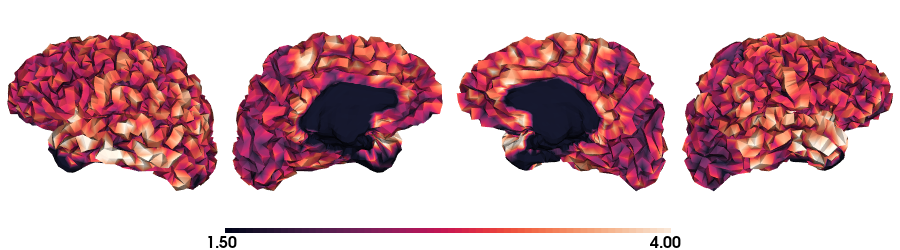

In [197]:
# Plot the surface
plot_hemispheres(gm_lh, gm_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,  color_bar='bottom')

# Curvature

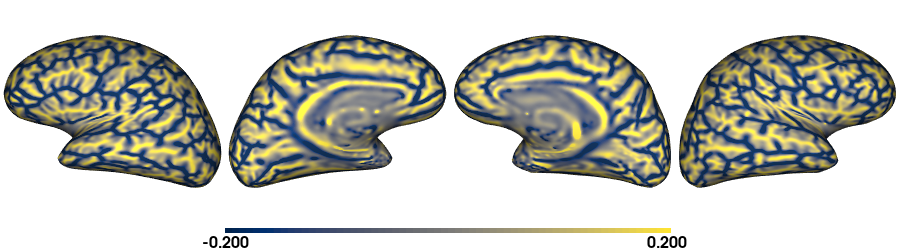

In [198]:
# Plot the surface
feat = load_feat(label='curv', surf='fsnative')
plot_hemispheres(inf_lh, inf_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap='cividis', transparent_bg=False,  color_bar='bottom')

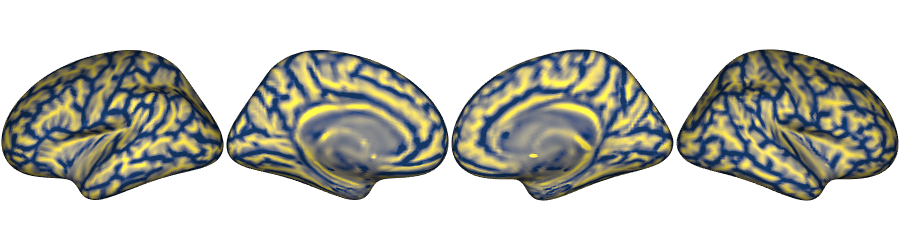

In [199]:
# Plot the surface
feat = load_feat(label='curv', surf='fsaverage5')
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(fs5_lhi, fs5_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2,0.2), cmap='cividis', transparent_bg=False)

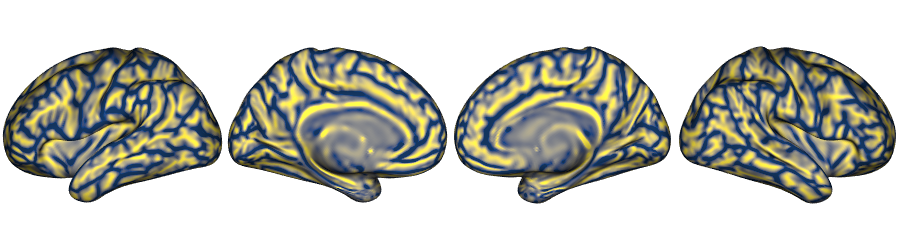

In [200]:
# Plot the surface
feat = load_feat(label='curv', surf='fsLR-32k')
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2,0.2), cmap='cividis', transparent_bg=False)

(9684,)


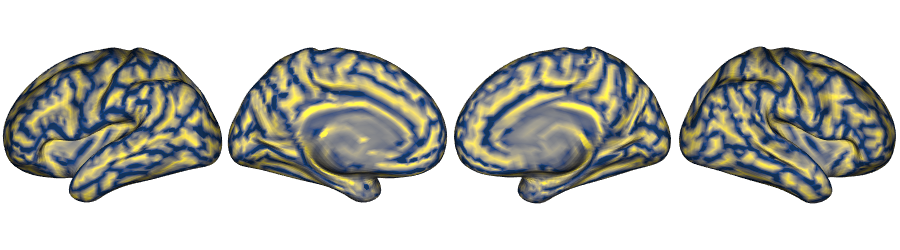

In [201]:
# Plot the surface
feat = load_feat(label='curv', surf='fsLR-5k')
print(feat.shape)
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
plot_hemispheres(c5k_lhi, c5k_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap='cividis', transparent_bg=False)

# DWI surface maps of `FA` and `ADC`
## FA pial fsLR-32k

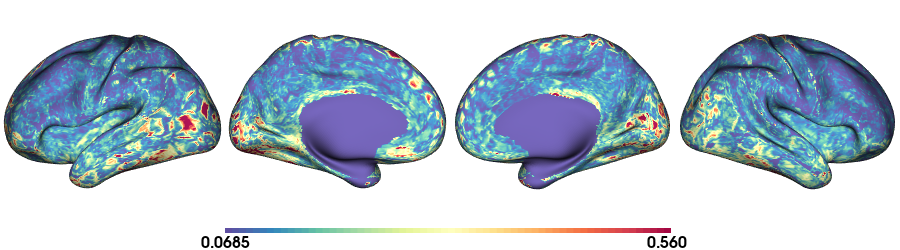

In [202]:
# Plot the surface
feat = load_feat(label='pial_FA', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat*mask, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Spectral_r', transparent_bg=False,  color_bar='bottom')

## FA midthickness fsLR-32k

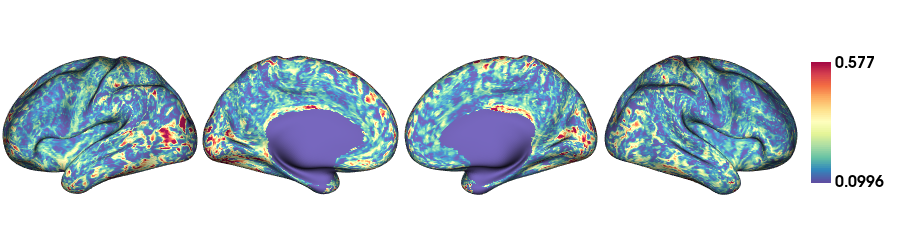

In [203]:
# Plot the surface
feat = load_feat(label='midthickness_FA', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat*mask, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Spectral_r', transparent_bg=False,  color_bar='right')


## FA white fsLR-32k

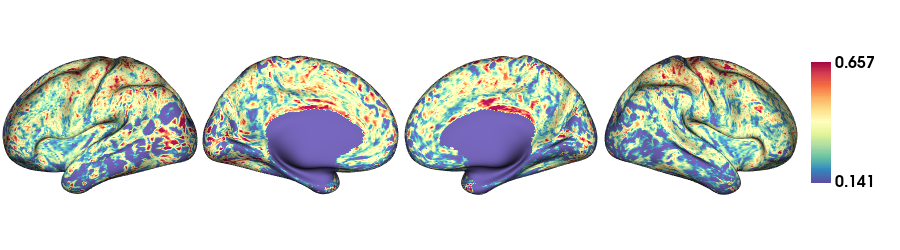

In [204]:
# Plot the surface
feat = load_feat(label='white_FA', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat*mask, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Spectral_r', transparent_bg=False,  color_bar='right')


## ADC pial fsLR-32k

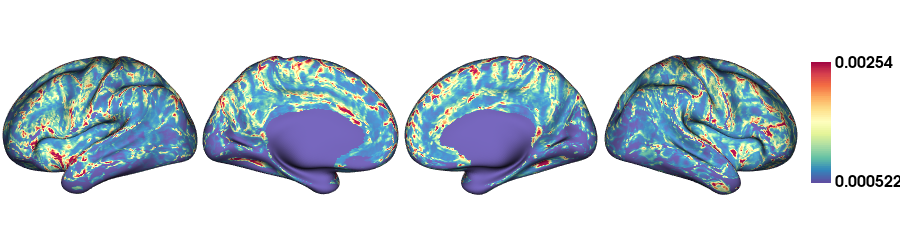

In [205]:
# Plot the surface
feat = load_feat(label='pial_ADC', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat*mask, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Spectral_r', transparent_bg=False, color_bar='right')


## ADC midthickness fsLR-32k

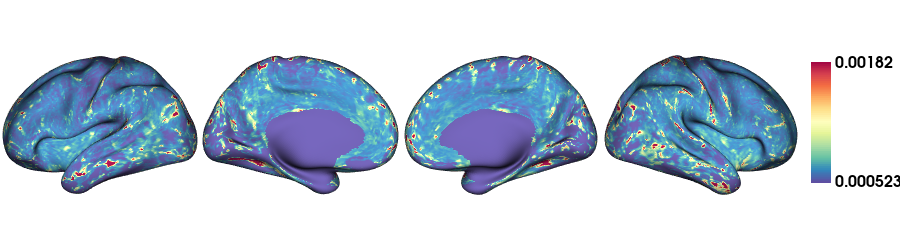

In [206]:
# Plot the surface
feat = load_feat(label='midthickness_ADC', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat*mask, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Spectral_r', transparent_bg=False, color_bar='right')


## ADC white fsLR-32k

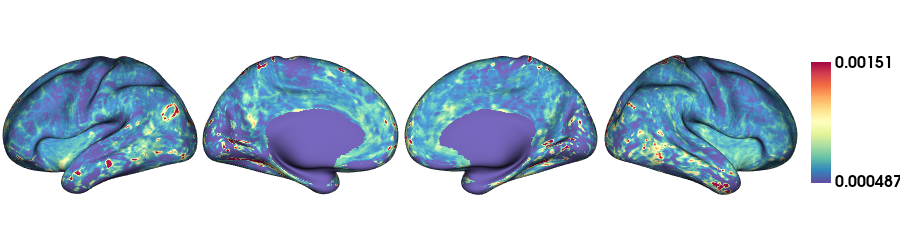

In [207]:
# Plot the surface
feat = load_feat(label='white_ADC', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat*mask, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Spectral_r', transparent_bg=False, color_bar='right')


# SC `fsLR-5k`

In [208]:
# load the matrix
vtx_sc = np.loadtxt(subjectDir + '/dwi/connectomes/' + subjectID + '_surf-fsLR-5k_desc-iFOD2-40M-SIFT2_full-connectome.txt', dtype=float, delimiter=' ')
vtx_sc = np.triu(vtx_sc,1)+vtx_sc.T

# Calculate the sum over the fsLR-5k vertices
vtx_SC_S = np.sum(vtx_sc,axis=1)

# Get the log sum
vtx_sc_log = np.log(vtx_SC_S)
vtx_sc_log[np.isneginf(vtx_sc_log)] = 0


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_39510/1586183077.py:9: RuntimeWarning: divide by zero encountered in log
  vtx_sc_log = np.log(vtx_SC_S)


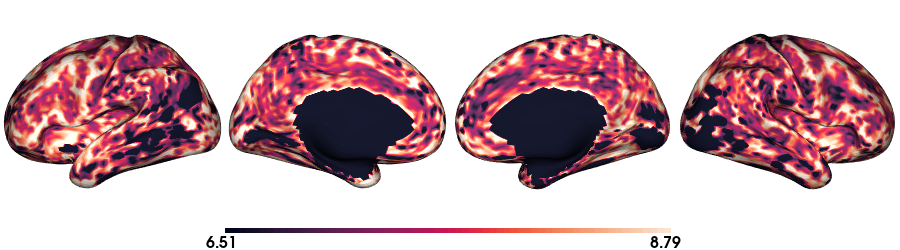

In [209]:
# Plot surface data
feat=vtx_sc_log
Range=(np.quantile(feat, 0.2), np.quantile(feat, 0.9))
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=feat, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), color_range=Range,
                 cmap='rocket',transparent_bg=False)

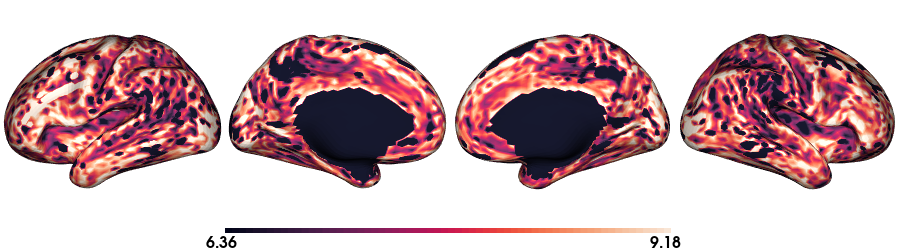

In [105]:
# Plot surface data
feat=vtx_sc_log
Range=(np.quantile(feat, 0.2), np.quantile(feat, 0.9))
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=feat, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), color_range=Range,
                 cmap='rocket',transparent_bg=False)

# `flair` surface maps

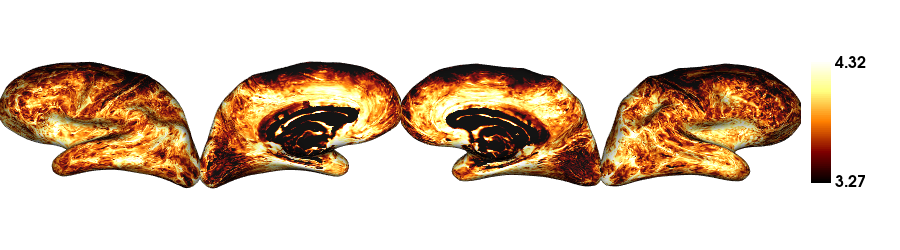

In [24]:
# Plot the surface
feat = load_feat(label='midthickness_flair', surf='fsnative')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(inf_lh, inf_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='afmhot', transparent_bg=False,  color_bar='right')


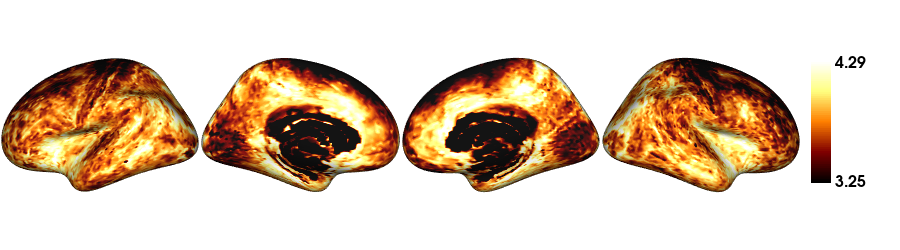

In [25]:
# Plot the surface
feat = load_feat(label='midthickness_flair', surf='fsaverage5')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(fs5_lhi, fs5_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='afmhot', transparent_bg=False,  color_bar='right')


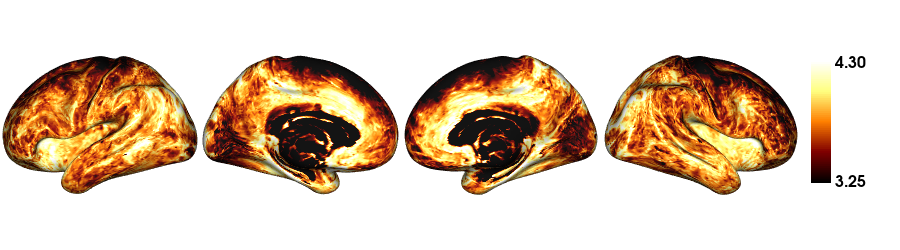

In [26]:
# Plot the surface
feat = load_feat(label='midthickness_flair', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='afmhot', transparent_bg=False,  color_bar='right')


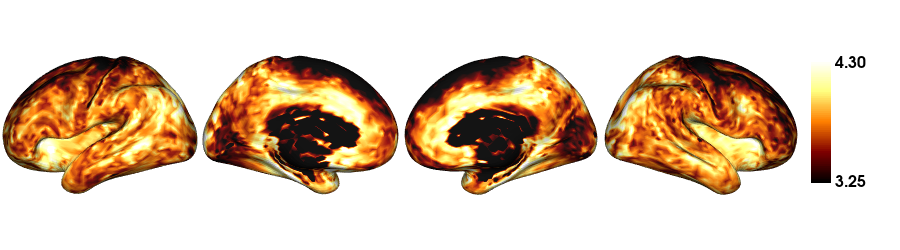

In [27]:
# Plot the surface
feat = load_feat(label='midthickness_flair', surf='fsLR-5k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(c5k_lhi, c5k_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='afmhot', transparent_bg=False,  color_bar='right')


# Vertex-wise connectomes
# GD `fsLR-5k`

In [234]:
# load the matrix
vtx_gd = np.load(subjectDir + '/dist/' + subjectID + '_surf-fsLR-5k_GD.shape.gii').darrays[0].data
#vtx_gd = np.load(subjectDir + '/dist/' + subjectID + '_atlas-schaefer-700_GD.shape.gii').darrays[0].data


# Calculate the sum over the fsLR-5k vertices
vtx_gd_S = np.sum(vtx_gd,axis=1)

# Plot surface data
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=vtx_gd_S, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), 
                 cmap='Blues',transparent_bg=False, color_range=None)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [235]:
subjectDir + '/dist/' + subjectID + '_surf-fsLR-5k_GD.shape.gii'

'/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/sub-HC062/ses-01/dist/sub-HC062_ses-01_surf-fsLR-5k_GD.shape.gii'

# SC `fsLR-5k`

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_39510/2151280836.py:9: RuntimeWarning: divide by zero encountered in log
  vtx_sc_log = np.log(vtx_SC_S)


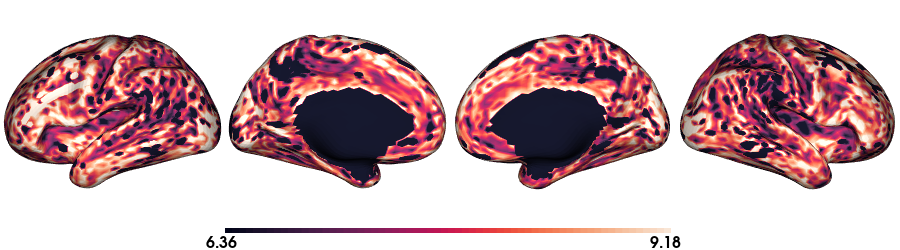

In [73]:
# load the matrix
vtx_sc = np.loadtxt(subjectDir + '/dwi/connectomes/' + subjectID + '_surf-fsRL-5k_desc-iFOD2-40M-SIFT2_full-connectome.txt', dtype=float, delimiter=' ')
vtx_sc = np.triu(vtx_sc,1)+vtx_sc.T

# Calculate the sum over the fsLR-5k vertices
vtx_SC_S = np.sum(vtx_sc,axis=1)

# Get the log sum
vtx_sc_log = np.log(vtx_SC_S)
vtx_sc_log[np.isneginf(vtx_sc_log)] = 0

# Plot surface data
feat=vtx_sc_log
Range=(np.quantile(feat, 0.2), np.quantile(feat, 0.9))
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=feat, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), color_range=Range,
                 cmap='rocket',transparent_bg=False)

# MPC `fsLR-5k`

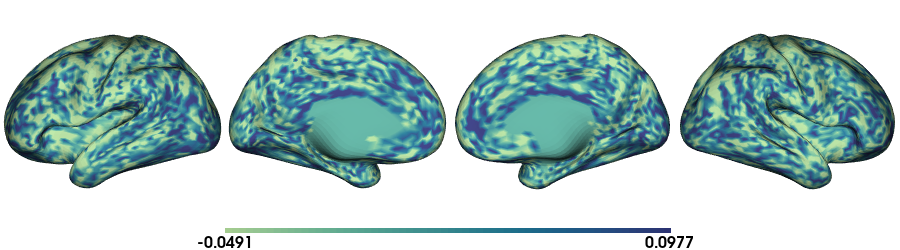

In [236]:
# load the matrix
mtx_mpc = nb.load(subjectDir + '/mpc/acq-T1map/' + subjectID + '_surf-fsLR-5k_desc-MPC.shape.gii').darrays[0].data
    
# Mirror the matrix
MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

# Calculate the sum over the fsLR-5k vertices
mpc_S = np.mean(MPC,axis=1)

# Plot surface data
feat=mpc_S
Range=(np.quantile(feat, 0.2), np.quantile(feat, 0.9))
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=feat, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), color_range=Range,
                 cmap='crest',transparent_bg=False)

# FC `fsLR-5k`

In [222]:
vtx_fc = np.loadtxt(subjectDir + '/func/'+func_acq+ '/surf/' + subjectID + '_surf-fsLR-5k_desc-FC.txt', dtype=float, delimiter=' ')

# Fischer transformation
FCz = np.arctanh(vtx_fc)

# replace inf with 0
FCz[~np.isfinite(FCz)] = 0

# Mirror the matrix
FCz = np.triu(FCz,1)+FCz.T

# Remove negative
# Positive correlations
fc_pos = np.copy(FCz)
fc_pos[(0>fc_pos)] = 0
    
# Calculate the sum over the fsLR-5k vertices
vtx_fc_S = np.sum(fc_pos, axis=1)

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_39510/1020513018.py:4: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(vtx_fc)


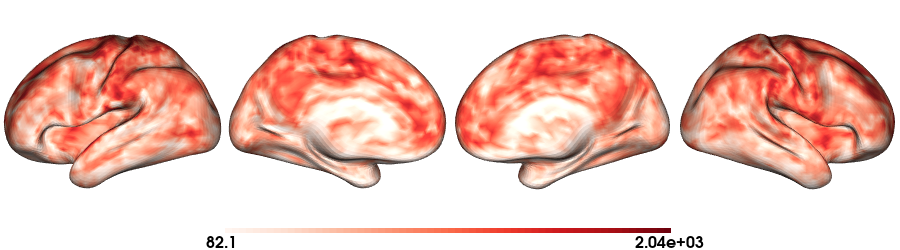

In [223]:
# Plot surface data
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=vtx_fc_S, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), 
                 cmap='Reds',transparent_bg=False, color_range=None)

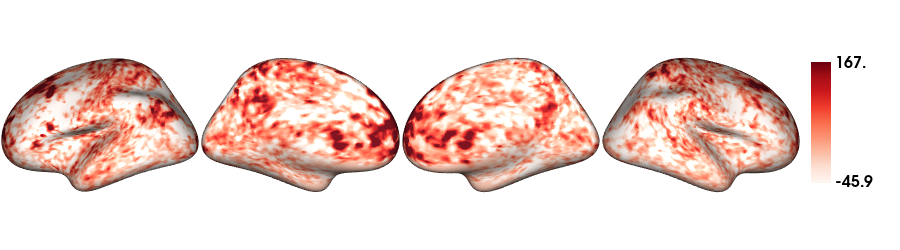

In [224]:
def load_timeseries(surf):
    P= subjectDir + '/func/'+func_acq+ '/surf/'
    fL=P+subjectID+'_hemi-L_surf-'+surf+'.func.gii'
    fR=P+subjectID+'_hemi-R_surf-'+surf+'.func.gii'
    fgiiL=nb.load(fL).darrays[0].data
    fgiiR=nb.load(fR).darrays[0].data
    feat = np.concatenate((fgiiL, fgiiR), axis=0)
    return(feat)

# Plot the surface
feat =load_timeseries('fsaverage5')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(fs5_lhi, fs5_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Reds', transparent_bg=False,  color_bar='right')


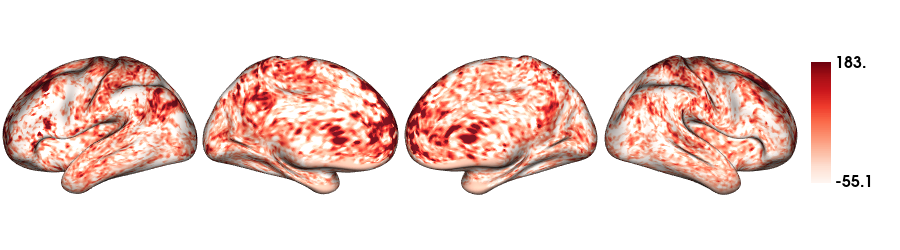

In [225]:
# Plot the surface
feat =load_timeseries('fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Reds', transparent_bg=False,  color_bar='right')


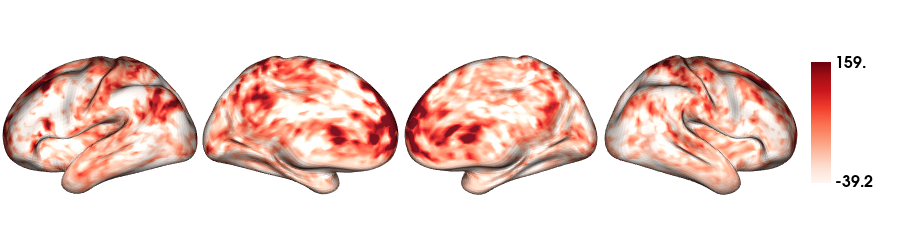

In [226]:
# Plot the surface
feat =load_timeseries('fsLR-5k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(c5k_lhi, c5k_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='Reds', transparent_bg=False,  color_bar='right')
